<h1> Jokes Classification </h1>

<h2> 1. Prerequisites </h2>

In [1]:
!pip install transformers datasets torch scikit-learn
!pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
from transformers import BartTokenizerFast
import re

<h2> 2. Import dataset </h2>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Positive Examples (Keep only entries where the Rating column is not null)

normalized_jester_df = pd.read_csv('/content/drive/MyDrive/Proiect NLP/Datasets/Preprocessed-Datasets/Positive-Examples/jester/normalized_jester.csv')
normalized_reddit_jokes_df = pd.read_csv('/content/drive/MyDrive/Proiect NLP/Datasets/Preprocessed-Datasets/Positive-Examples/joke-dataset/normalized_reddit_jokes.csv')
normalized_stupidstuff_df = pd.read_csv('/content/drive/MyDrive/Proiect NLP/Datasets/Preprocessed-Datasets/Positive-Examples/joke-dataset/normalized_stupidstuff.csv')

normalized_jester_df = normalized_jester_df[normalized_jester_df['Rating'].notna()]
normalized_reddit_jokes_df = normalized_reddit_jokes_df[normalized_reddit_jokes_df['Rating'].notna()]
normalized_stupidstuff_df = normalized_stupidstuff_df[normalized_stupidstuff_df['Rating'].notna()]

# Negative Examples (All of them, put 0 in the Rating column)

news_category_dataset_df = pd.read_csv('/content/drive/MyDrive/Proiect NLP/Datasets/Preprocessed-Datasets/Negative-Examples/News_Category_Dataset_v3/News_Category_Dataset_v3.csv')
news_category_dataset_df['Rating'] = news_category_dataset_df['Rating'].fillna(0.0)

df = pd.concat([normalized_jester_df, normalized_reddit_jokes_df, normalized_stupidstuff_df, news_category_dataset_df], ignore_index=True)
df = df.dropna(subset=['Body'])
df = df[df['Body'].str.strip() != '']

def preprocessed_sample(sample):
  sample = str(sample)
  sample = re.sub(r'[^a-zA-Z0-9\s]', '', sample) # Only letters (lowercase and uppercase) + digits
  sample = sample.lower() # Everything lowercase
  sample = re.sub(r'\d+', 'NUMBER', sample) # Replace all numerical values with a common label.
  return sample

df['Body'] = df['Body'].apply(preprocessed_sample)
print(df[df['Rating'] != 0.0])
print(df[df['Rating'] == 0.0])


          ID Title       Category  \
0          5   NaN            NaN   
1          7   NaN            NaN   
2          8   NaN            NaN   
3         13   NaN            NaN   
4         15   NaN            NaN   
...      ...   ...            ...   
198457  3765   NaN  Miscellaneous   
198458  3766   NaN  Miscellaneous   
198462  3770   NaN  Miscellaneous   
198464  3772   NaN  Miscellaneous   
198465  3773   NaN  Miscellaneous   

                                                     Body    Rating  
0       q\twhats o j simpsons internet address \na\tsl...  0.153659  
1       how many feminists does it take to screw in a ...  0.145475  
2       q did you hear about the dyslexic devil worshi...  0.321407  
3       they asked the japanese visitor if they have e...  0.334060  
4       q  what did the blind person say when given so...  0.212328  
...                                                   ...       ...  
198457  britain decided it was time to switch left lan...  0.8000

<h2> 3. Train / Val split

In [5]:
import torch
from torch.utils.data import Dataset
from transformers import (
    BartTokenizerFast,
    BartForSequenceClassification,
    Trainer,
    TrainingArguments,
)

from sklearn.model_selection import train_test_split

tokenizer = BartTokenizerFast.from_pretrained("facebook/bart-base")

model = BartForSequenceClassification.from_pretrained(
    "facebook/bart-base",
    num_labels=1,
    problem_type="regression"
)

TEST_PERCENTAGE_FROM_ALL = 0.2
VAL_PERCENTAGE_FROM_TRAIN = 0.2


X_train_zero = df[df['Rating'] == 0.0]['Body']
y_train_zero = df[df['Rating'] == 0.0]['Rating']

X_train_notzero = df[df['Rating'] != 0.0]['Body']
y_train_notzero = df[df['Rating'] != 0.0]['Rating']

X_train_zero, X_test_zero, y_train_zero, y_test_zero = train_test_split(X_train_zero, y_train_zero, test_size=TEST_PERCENTAGE_FROM_ALL, random_state=17)
X_train_zero, X_val_zero, y_train_zero, y_val_zero = train_test_split(X_train_zero, y_train_zero, test_size=VAL_PERCENTAGE_FROM_TRAIN, random_state=17)

X_train_notzero, X_test_notzero, y_train_notzero, y_test_notzero = train_test_split(X_train_notzero, y_train_notzero, test_size=TEST_PERCENTAGE_FROM_ALL, random_state=17)
X_train_notzero, X_val_notzero, y_train_notzero, y_val_notzero = train_test_split(X_train_notzero, y_train_notzero, test_size=VAL_PERCENTAGE_FROM_TRAIN, random_state=17)

X_train = pd.concat([X_train_zero, X_train_notzero])
y_train = pd.concat([y_train_zero, y_train_notzero])

X_val = pd.concat([X_val_zero, X_val_notzero])
y_val = pd.concat([y_val_zero, y_val_notzero])

X_test = pd.concat([X_test_zero, X_test_notzero])
y_test = pd.concat([y_test_zero, y_test_notzero])


train_enc = tokenizer(
    X_train.tolist(),
    truncation=True,
    padding="max_length",
    max_length=64,
)
val_enc = tokenizer(
    X_val.tolist(),
    truncation=True,
    padding="max_length",
    max_length=64,
)
test_enc = tokenizer(
    X_test.tolist(),
    truncation=True,
    padding="max_length",
    max_length=64,
)
print('Train zero:', X_train_zero.shape[0], 'Train not zero:', X_train_notzero.shape[0])
print('Val zero:', X_val_zero.shape[0], 'Val not zero:', X_val_notzero.shape[0])
print('Test zero:', X_test_zero.shape[0], 'Test not zero:', X_test_notzero.shape[0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train zero: 159576 Train not zero: 85873
Val zero: 39894 Val not zero: 21469
Test zero: 49868 Test not zero: 26836


<h2> 4. Dataset Creation <h2>

In [6]:
class TextRegressionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels.tolist(), dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = self.labels[idx].unsqueeze(0)
        return item
train_dataset = TextRegressionDataset(train_enc, y_train)
val_dataset   = TextRegressionDataset(val_enc,   y_val)
test_dataset  = TextRegressionDataset(test_enc,  y_test)

In [7]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./bart_regression",
    do_train=True,
    do_eval=True,
    eval_steps=500,
    logging_steps=50,
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0.01,
    save_steps=500,
    save_total_limit=2,
    optim="adamw_torch",
    fp16=True
)

def compute_metrics(eval_pred):
    if hasattr(eval_pred, "predictions"):
        preds = eval_pred.predictions
        labels = eval_pred.label_ids
    else:
        preds, labels = eval_pred
    if isinstance(preds, tuple):
        preds = preds[0]
    preds = preds.squeeze()
    labels = labels.squeeze()
    mse = mean_squared_error(labels, preds)
    return {
        "mse": mse,
        "rmse": mse ** 0.5,
        "mae": mean_absolute_error(labels, preds),
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dragos-ciobanu232 (dragos-ciobanu232-university-of-bucharest) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,0.213300
100,0.005900
150,0.005900
200,0.005400
250,0.005500
300,0.003600
350,0.006000
400,0.002800
450,0.004300
500,0.005600


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:393: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:393: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning 

TrainOutput(global_step=23013, training_loss=0.004195432481751553, metrics={'train_runtime': 1789.8734, 'train_samples_per_second': 411.396, 'train_steps_per_second': 12.857, 'total_flos': 2.822831234741261e+16, 'train_loss': 0.004195432481751553, 'epoch': 3.0})

<h2> 6. Evaluate </h2>

In [ ]:
test_metrics = trainer.evaluate(eval_dataset=test_dataset)

print("Test metrics:",       test_metrics)

Test metrics: {'eval_loss': 0.003425551112741232, 'eval_mse': 0.003425551112741232, 'eval_rmse': 0.058528207838111974, 'eval_mae': 0.009452156722545624, 'eval_runtime': 547.193, 'eval_samples_per_second': 140.177, 'eval_steps_per_second': 4.381, 'epoch': 3.0}


In [ ]:
pred_output = trainer.predict(test_dataset)
preds = pred_output.predictions
if isinstance(preds, tuple):
    preds = preds[0]
preds = preds.squeeze()
labels = pred_output.label_ids.squeeze()

thr 0.00 | P=0.673  R=0.673  F1(weighted)=0.673
thr 0.10 | P=0.732  R=0.656  F1(weighted)=0.526
thr 0.20 | P=0.745  R=0.654  F1(weighted)=0.523
thr 0.30 | P=0.752  R=0.654  F1(weighted)=0.521
thr 0.40 | P=0.753  R=0.653  F1(weighted)=0.519
thr 0.50 | P=0.757  R=0.652  F1(weighted)=0.517
thr 0.60 | P=0.753  R=0.652  F1(weighted)=0.516
thr 0.70 | P=0.760  R=0.651  F1(weighted)=0.514
thr 0.80 | P=0.423  R=0.650  F1(weighted)=0.512
thr 0.90 | P=0.423  R=0.650  F1(weighted)=0.512
thr 1.00 | P=0.423  R=0.650  F1(weighted)=0.512


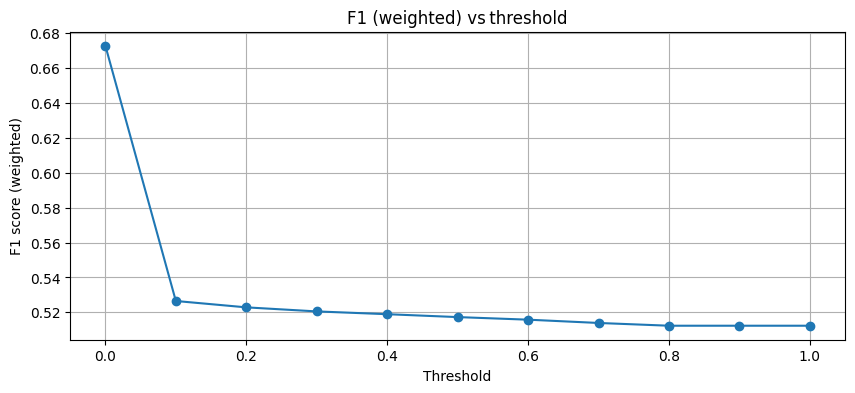


Best threshold = 0.00

Confusion matrix
 [[37346 12522]
 [12562 14274]] 

              precision    recall  f1-score   support

Non‑Joke (0)       0.75      0.75      0.75     49868
   Joke (>0)       0.53      0.53      0.53     26836

    accuracy                           0.67     76704
   macro avg       0.64      0.64      0.64     76704
weighted avg       0.67      0.67      0.67     76704



In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)


def find_best_threshold_from_preds(
        preds: np.ndarray,
        labels: np.ndarray,
        *,
        apply_sigmoid: bool = False,
        thresh_grid = np.arange(0.0, 1.01, 0.1),
        average: str = "weighted"
    ):
    probs = 1 / (1 + np.exp(-preds)) if apply_sigmoid else preds.copy()

    best_f1, best_thresh = -1.0, 0.5
    history = {"threshold": [], "precision": [], "recall": [], "f1": []}

    for t in thresh_grid:
        bin_pred = (probs > t).astype(int)
        p, r, f, _ = precision_recall_fscore_support(
            labels, bin_pred, average=average, zero_division=0
        )

        history["threshold"].append(t)
        history["precision"].append(p)
        history["recall"].append(r)
        history["f1"].append(f)

        if f > best_f1:
            best_f1, best_thresh = f, t

        print(f"thr {t:4.2f} | P={p:5.3f}  R={r:5.3f}  F1({average})={f:5.3f}")

    plt.figure(figsize=(10, 4))
    plt.plot(history["threshold"], history["f1"], marker="o")
    plt.xlabel("Threshold")
    plt.ylabel(f"F1 score ({average})")
    plt.title(f"F1 ({average}) vs threshold")
    plt.grid(True)
    plt.show()

    return best_thresh, history

binary_true = (labels > 0).astype(int)

best_thr, _ = find_best_threshold_from_preds(
    preds, binary_true,
    apply_sigmoid=False,
    average="weighted"
)
print(f"\nBest threshold = {best_thr:.2f}")

binary_pred_best = (preds > best_thr).astype(int)

cm = confusion_matrix(binary_true, binary_pred_best)
print("\nConfusion matrix\n", cm, "\n")
print(classification_report(binary_true, binary_pred_best,
                            target_names=['Non‑Joke (0)', 'Joke (>0)']))